In [47]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import aim

In [48]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.models.unet import UNet
from src.training.metrics import dice_loss
from src.training.metrics import evaluate
from src.training.train import train
from src.data.datasets import ACDCDataset


In [49]:

dataset = ACDCDataset(path='../../training/', verbose=1)

Loaded saved dataset from /worskpace/tagroi/checkpoints/acdc_dataset.pt


In [50]:
train_set, val_set, _ = random_split(dataset, [8, 4, 940], generator=torch.Generator().manual_seed(42))
loader_train = DataLoader(train_set, batch_size=4, shuffle=True)
loader_val = DataLoader(val_set, batch_size=4, shuffle=False)

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [52]:
model = UNet(n_channels=1, n_classes=4, bilinear=True).double()
model = nn.DataParallel(model).to(device)

In [53]:
%load_ext aim

The aim extension is already loaded. To reload it, use:
  %reload_ext aim


In [54]:
run = aim.Run()

In [55]:
train(model, run=run, loader_train=loader_train, loader_val=loader_val, device=device)

Epoch 24 	 Loss 2.298 	 Dice 02.621	 Val. Dice 02.621: 100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


## Some other stuff

In [28]:
image, target = next(iter(loader_val))
image.shape, image.dtype, target.shape, target.dtype

(torch.Size([2, 1, 256, 256]),
 torch.float64,
 torch.Size([2, 256, 256]),
 torch.float32)

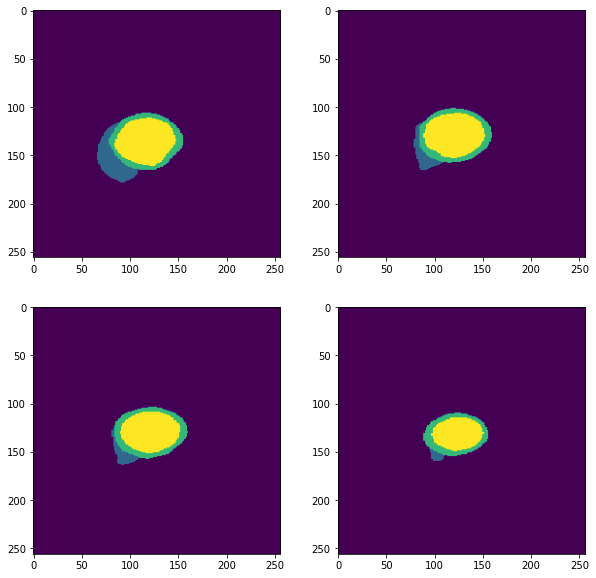

In [13]:
target1, target2 = dataset[12][1], dataset[14][1]
target3, target4 = dataset[15][1], dataset[17][1]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(target1), ax[0, 1].imshow(target2)
ax[1, 0].imshow(target3), ax[1, 1].imshow(target4)

plt.show()

In [15]:
from src.training.metrics import dc

In [21]:
sum([dc(target1, target2), dc(target3, target4)]) / 2

tensor(0.8160)

In [19]:
dc(
    torch.cat([target1.unsqueeze(0), target3.unsqueeze(0)], dim=0),
    torch.cat([target2.unsqueeze(0), target4.unsqueeze(0)], dim=0)
)


tensor(0.8147)

In [10]:
output = model(image)
output.shape, output.dtype

(torch.Size([2, 4, 256, 256]), torch.float64)

In [18]:
F.one_hot(output.argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).bool().shape

torch.Size([2, 4, 256, 256])

In [18]:
oh_target = F.one_hot(target.long(), model.n_classes).permute(0, 3, 1, 2)
oh_target.shape

torch.Size([2, 4, 256, 256])

## Brain MRI U-NET

In [ ]:
from brainet.unet import UNet

brainet = UNet()
brainet.load_state_dict(torch.load('../checkpoints/brainet-e012d006.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    output = brainet(inp)

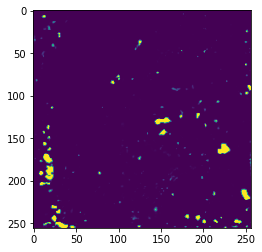

In [ ]:
plt.imshow(output[0, 0])

## Eval

In [56]:
example, label = next(iter(loader_val))
out = model(example)

In [57]:
example.shape, label.shape, out.shape

(torch.Size([4, 1, 256, 256]),
 torch.Size([4, 256, 256]),
 torch.Size([4, 4, 256, 256]))

In [58]:
predicted_mask = F.softmax(out, dim=1).argmax(dim=1).cpu().detach().numpy().copy()

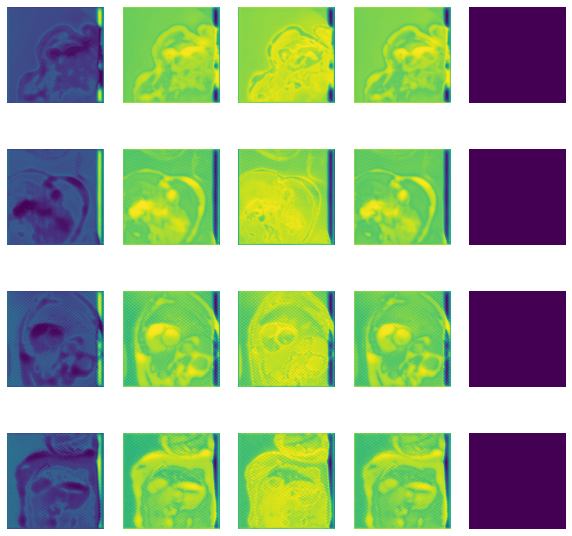

In [60]:
fig, ax = plt.subplots(4, 5, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(out.cpu().detach().numpy()[i, j])
        ax[i, j].axis('off')

    ax[i, 4].imshow(predicted_mask[i]), ax[i, 4].axis('off')

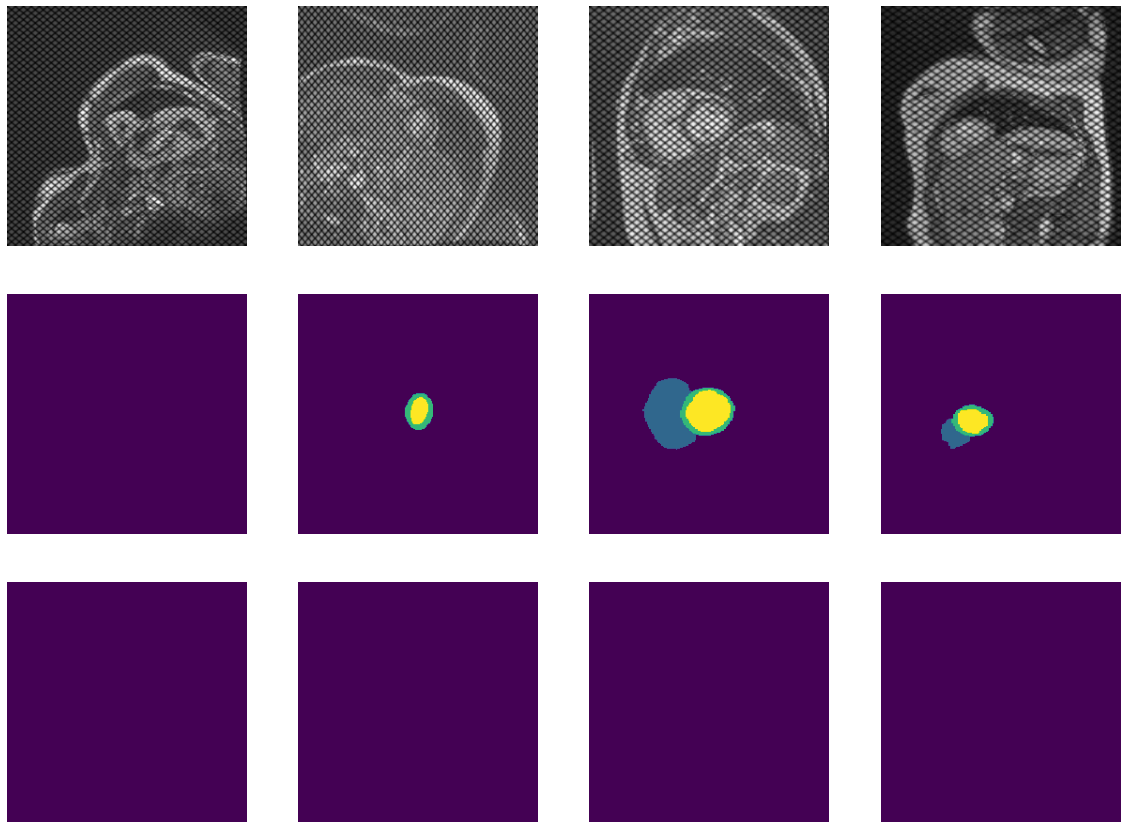

In [61]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i in range(0, 4):
    ax[0, i % 5].imshow(example[i, 0], cmap='gray')
    ax[1, i % 5].imshow(label[i], alpha=1)
    ax[2, i % 5].imshow(predicted_mask[i], alpha=1.)
    ax[0, i % 5].axis('off'), ax[1, i % 5].axis('off'), ax[2, i % 5].axis('off')

In [21]:
example, mask = dataset[1]
output = model(example.unsqueeze(0))

In [22]:
example.shape, mask.shape, output.shape

(torch.Size([1, 256, 256]),
 torch.Size([256, 256]),
 torch.Size([1, 4, 256, 256]))

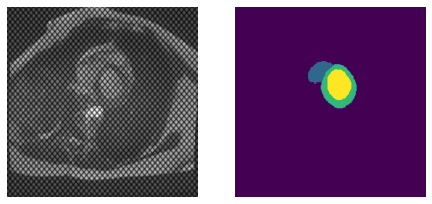

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))

ax[0].imshow(example[0, ...], cmap='gray'), ax[0].axis('off')
ax[1].imshow(mask[...]), ax[1].axis('off')

plt.show()

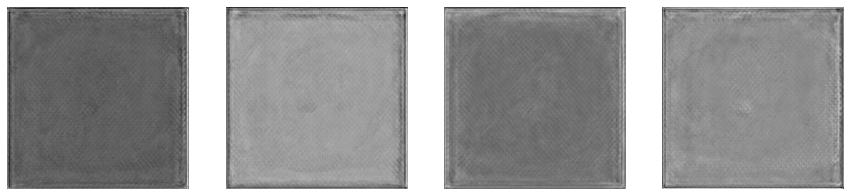

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    ax[i].imshow(output[0, i, ...].detach().numpy(), cmap='gray'), ax[i].axis('off')

plt.show()